In [1]:
from create_dataset import CreateDataset
from train_models import ClassifierTrainer, RegressorTrainer
from callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, ModelCheckpointCallback

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/train_models.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [9]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=2,
                            device='cpu',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.7111 Acc: 0.5398 Rec: 0.5506 Prec: 0.5425


Epoch [20/100] Train Loss: 0.7077 Acc: 0.5476 Rec: 0.5626 Prec: 0.5496


Epoch [30/100] Train Loss: 0.7062 Acc: 0.5500 Rec: 0.5646 Prec: 0.5520


Epoch [40/100] Train Loss: 0.7058 Acc: 0.5503 Rec: 0.5639 Prec: 0.5524


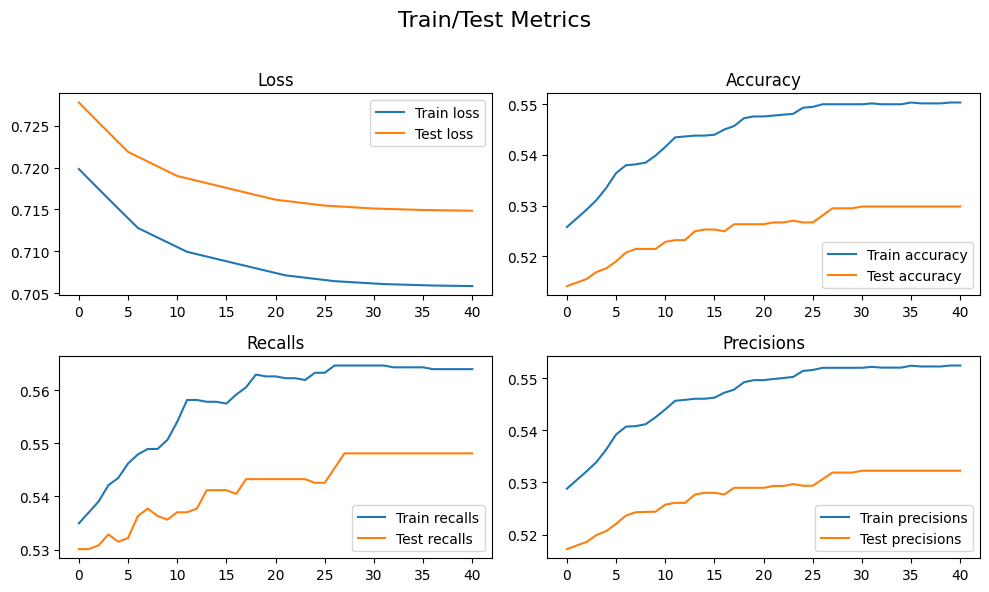

In [10]:
trainer.plot_metrics()

## multyclass classification

In [11]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [13]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [14]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [15]:
num_classes = len(np.unique(y_train))
num_classes

3

In [16]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [17]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [18]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [19]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=num_classes,
                            device='mps',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.9679 Acc: 0.3667 Rec: 0.3667 Prec: 0.4853


Epoch [20/100] Train Loss: 0.9008 Acc: 0.6625 Rec: 0.6625 Prec: 0.5576
Epoch [30/100] Train Loss: 0.8414 Acc: 0.6667 Rec: 0.6667 Prec: 0.5450


Epoch [40/100] Train Loss: 0.7932 Acc: 0.7037 Rec: 0.7037 Prec: 0.8876
Epoch [50/100] Train Loss: 0.7589 Acc: 0.7778 Rec: 0.7778 Prec: 0.9098
Epoch [60/100] Train Loss: 0.7335 Acc: 0.8114 Rec: 0.8114 Prec: 0.9211


Epoch [70/100] Train Loss: 0.7126 Acc: 0.8485 Rec: 0.8485 Prec: 0.9373


Epoch [80/100] Train Loss: 0.7027 Acc: 0.8633 Rec: 0.8633 Prec: 0.9359


Epoch [90/100] Train Loss: 0.7001 Acc: 0.8633 Rec: 0.8633 Prec: 0.9359


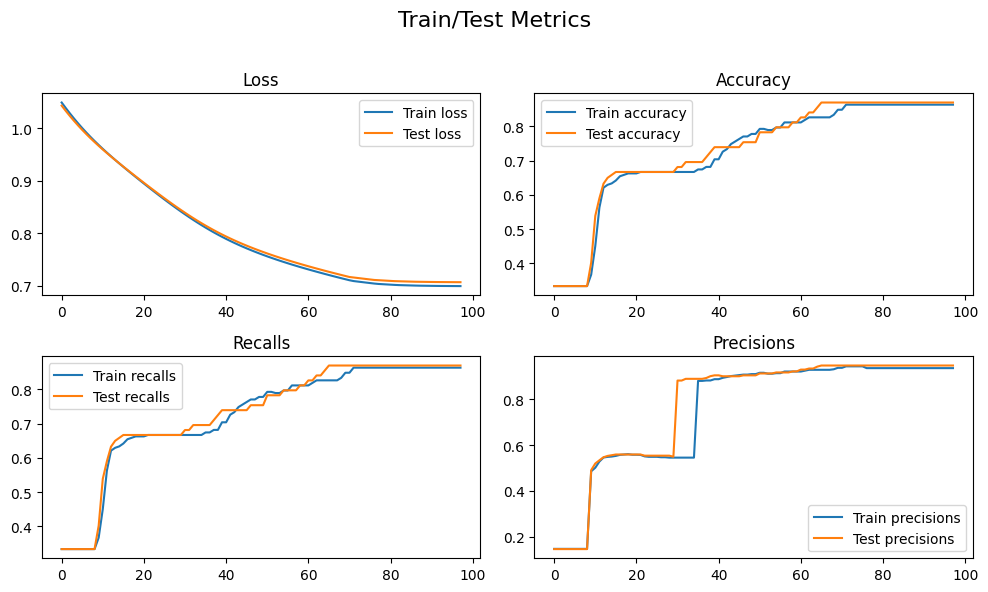

In [20]:
trainer.plot_metrics()

## regression

In [21]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [23]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [24]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [25]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [26]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [28]:
trainer = RegressorTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device='cpu',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=10,
            info_every_iter=1,
            show_val_metrics=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 7709864.2596 MSE: 7709867.0000 MAE: 2180.5627 RMSE: 2776.6647
Epoch [1/10] Val Loss: 6697548.6023 MSE: 6697547.5000 MAE: 2000.1938 RMSE: 2587.9620


Epoch [2/10] Train Loss: 5938974.4285 MSE: 5938974.0000 MAE: 1809.5310 RMSE: 2437.0010
Epoch [2/10] Val Loss: 3476107.7592 MSE: 3476107.2500 MAE: 1310.5515 RMSE: 1864.4322


Epoch [3/10] Train Loss: 2493976.1165 MSE: 2493976.2500 MAE: 1121.8851 RMSE: 1579.2328
Epoch [3/10] Val Loss: 1535540.2339 MSE: 1535540.0000 MAE: 948.7598 RMSE: 1239.1691


Epoch [4/10] Train Loss: 1634769.7446 MSE: 1634769.1250 MAE: 973.6359 RMSE: 1278.5809
Epoch [4/10] Val Loss: 1355769.5242 MSE: 1355769.3750 MAE: 906.8580 RMSE: 1164.3751


Epoch [5/10] Train Loss: 1477476.0878 MSE: 1477475.3750 MAE: 924.0047 RMSE: 1215.5144
Epoch [5/10] Val Loss: 1250854.2430 MSE: 1250854.2500 MAE: 860.6480 RMSE: 1118.4160


Epoch [6/10] Train Loss: 1388732.3985 MSE: 1388732.2500 MAE: 886.4330 RMSE: 1178.4448
Epoch [6/10] Val Loss: 1189248.9153 MSE: 1189248.8750 MAE: 828.4571 RMSE: 1090.5269


Epoch [7/10] Train Loss: 1336630.8702 MSE: 1336631.2500 MAE: 860.2162 RMSE: 1156.1277
Epoch [7/10] Val Loss: 1152852.2056 MSE: 1152852.2500 MAE: 805.6120 RMSE: 1073.7096


Epoch [8/10] Train Loss: 1305717.0800 MSE: 1305717.5000 MAE: 841.9145 RMSE: 1142.6800
Epoch [8/10] Val Loss: 1131606.8350 MSE: 1131606.8750 MAE: 789.7241 RMSE: 1063.7701


Epoch [9/10] Train Loss: 1287100.7290 MSE: 1287100.8750 MAE: 829.4356 RMSE: 1134.5047
Epoch [9/10] Val Loss: 1118822.7889 MSE: 1118822.8750 MAE: 778.3840 RMSE: 1057.7442


Epoch [10/10] Train Loss: 1275531.4330 MSE: 1275530.8750 MAE: 820.9799 RMSE: 1129.3940
Epoch [10/10] Val Loss: 1110976.4133 MSE: 1110976.3750 MAE: 770.4671 RMSE: 1054.0286


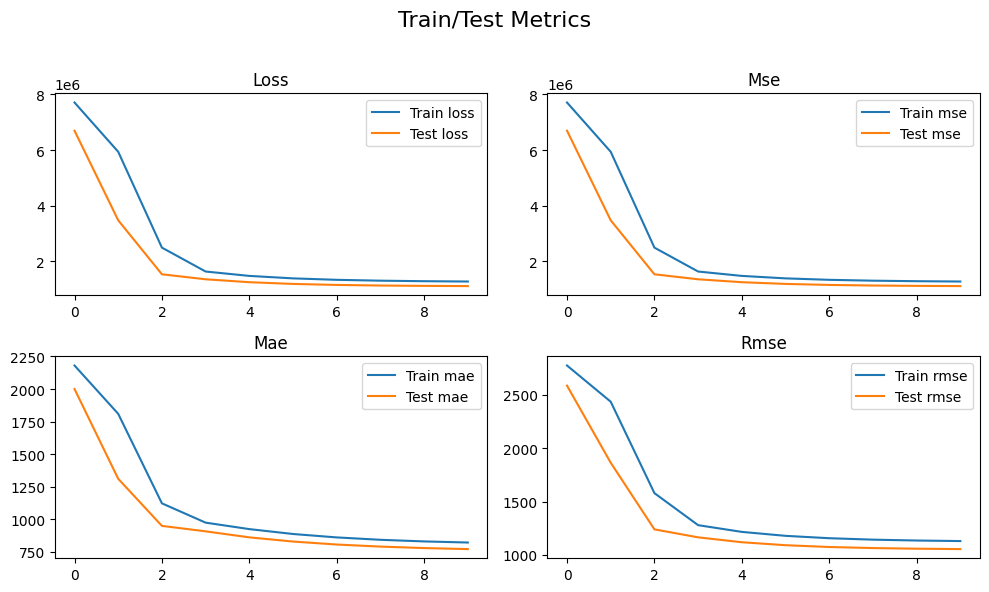

In [29]:
trainer.plot_metrics()